#  CIFAR CNN

<font color="red">Train your best CNN model on the CIFAR dataset. Perform Champion vs Challenger bake off !
</font>

<img src="https://karpathy.github.io/assets/cifar_preview.png"/>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import numpy as np

### Load Dataset

In [6]:
import numpy as np
import os
import pickle

num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dict = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        if i == 1:
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose(0, 2, 3, 1)

    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

data_dir = r'C:\Users\Sam\Desktop\NW Work\Spring Work\MSiA-SQ\Data\MSiA 432\06_lecture\cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print(x_train.shape, y_train.shape)

x_train /= 255
x_test /= 255

print(x_train.shape, y_train.shape)


(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)


### Sample Dataset

CIFAR Data Size : (10000, 32, 32, 3)


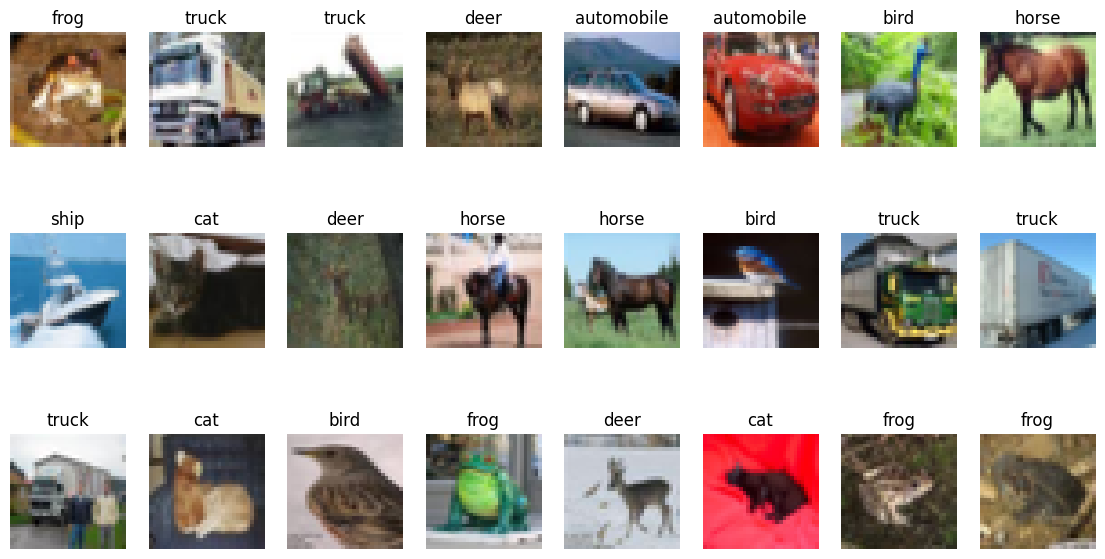

In [7]:
print ("CIFAR Data Size :" , x_test.shape)
plt.rcParams['figure.figsize'] = (8,8)

# Display the first few  training images
images_and_labels = list(zip(x_train, y_train))
plt.figure(figsize=(14,10))
for index, (image, label) in enumerate(images_and_labels[:24]):
    plt.subplot(4, 8, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    plt.title(class_names[index[0][0]])
plt.show()

### Data Augmentation Layers

*Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).*

https://www.tensorflow.org/tutorials/images/data_augmentation

In [8]:
IMG_SIZE = 32

#resize and resale 
resize_and_rescale = Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

#data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

### Define Models

In [9]:
def base_model_1():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model


In [10]:
from keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, ZeroPadding2D
from keras import Model

def resnet_block(inputs, num_filters, stride=1, downsampling=False):
    x = Conv2D(num_filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    if downsampling:
        inputs = Conv2D(num_filters, (1, 1), strides=stride, padding='same')(inputs)
        inputs = BatchNormalization()(inputs)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def base_model_2():
    inputs = Input(shape=(32, 32, 3))

    x = ZeroPadding2D(padding=(3, 3))(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, stride=2, downsampling=True)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, stride=2, downsampling=True)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, stride=2, downsampling=True)
    x = resnet_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [11]:
model = base_model_1()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                      

In [12]:
# Compile base_model_1
model = base_model_1()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train Model

In [15]:
# Fit model
epochs = 50
batch_size=32

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Define callback
my_callbacks = [
    EarlyStopping(patience=25),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                    save_best_only=True,
                    mode='max',
                    monitor='val_accuracy'),
    TensorBoard(log_dir='logs'),
]

In [17]:
# fits the model on batches with real-time data augmentation:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
        #   callbacks=my_callbacks
          )

Epoch 1/50
  48/1563 [..............................] - ETA: 20:53 - loss: 3.4776 - accuracy: 0.1283

KeyboardInterrupt: 

### Persist Model

In [ ]:
#save model to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

### Test Model

In [ ]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 11ms/step - loss: 1.0822 - accuracy: 0.8400
Test result: 84.000 loss: 1.082


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

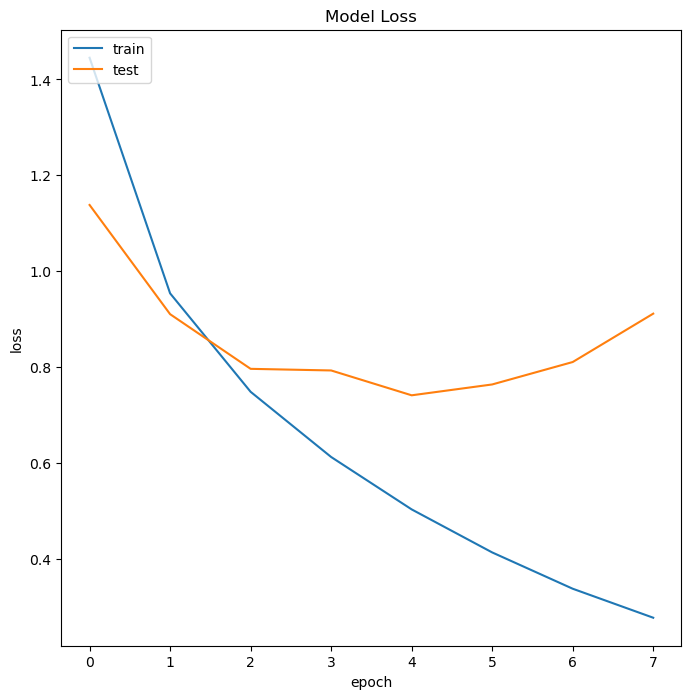

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

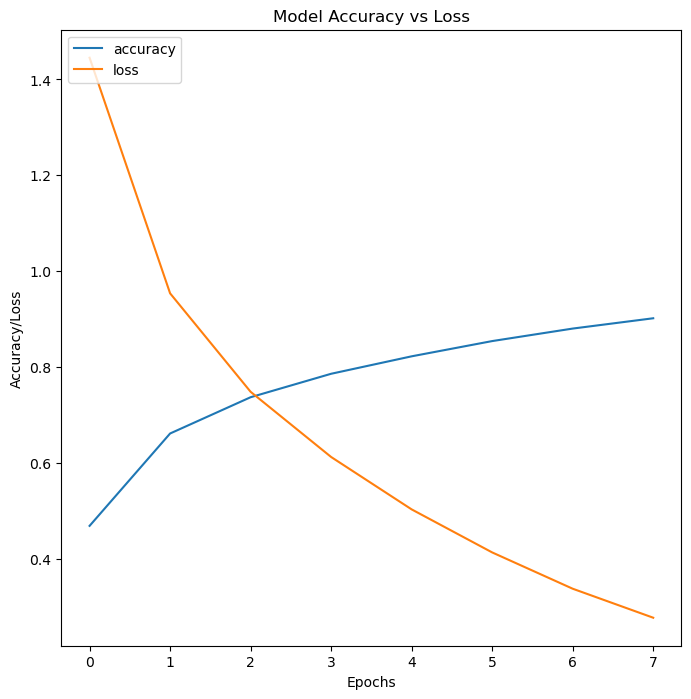

In [ ]:
# summarize Accuracy Vs Loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy vs Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epochs')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 16ms/step


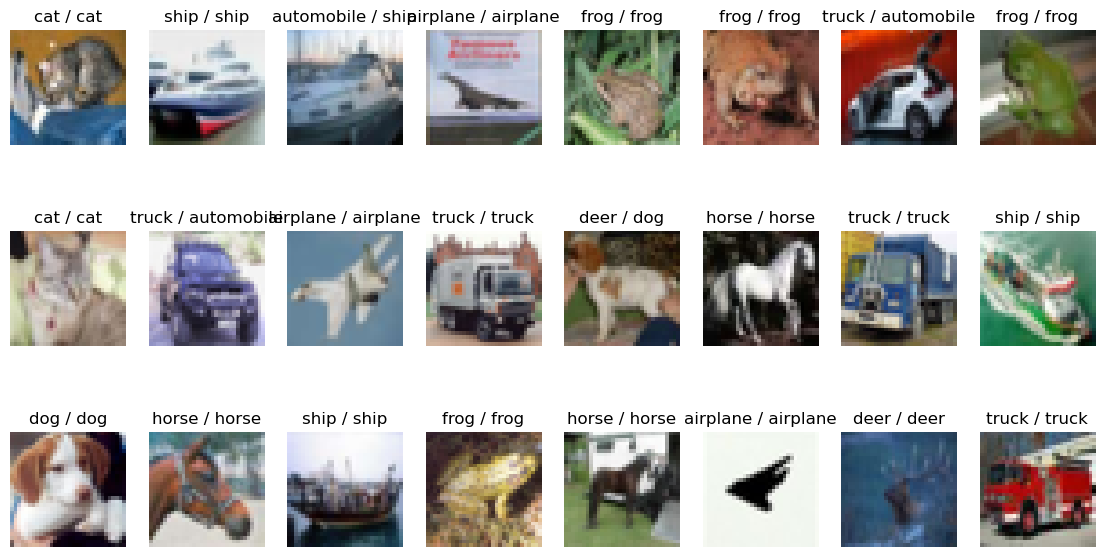

In [ ]:
# Display the first few images
images_and_labels = list(zip(x_test, y_test))
plt.figure(figsize=(14,10))
for index, (image, label) in enumerate(images_and_labels[:24]):
    plt.subplot(4, 8, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred= pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[index[0][0]])
plt.show()